In [34]:
from datasets import load_dataset

# Analyzing the content of the columns

In [35]:
ds = load_dataset("Elfsong/Venus_t")

In [36]:
ds['train'].features

{'question_id': Value(dtype='int64', id=None),
 'name': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'acRate': Value(dtype='float64', id=None),
 'difficulty': Value(dtype='string', id=None),
 'topics': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'runtimeDistribution': Value(dtype='string', id=None),
 'memoryDistribution': Value(dtype='string', id=None),
 'rt_list': [{'code': Value(dtype='string', id=None),
   'runtime': Value(dtype='string', id=None)}],
 'rt_solution_count': Value(dtype='int64', id=None),
 'mm_list': [{'code': Value(dtype='string', id=None),
   'memory': Value(dtype='string', id=None)}],
 'mm_solution_count': Value(dtype='int64', id=None),
 'code_prompt': Value(dtype='string', id=None),
 'test_case_generator': Value(dtype='string', id=None),
 'entry_point': Value(dtype='string', id=None),
 'libraries': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'import_code': Value(dtype='string', id

In [37]:
rt_dist = ds['train'][0]['runtimeDistribution']

In [38]:
len(ds['train'])

1527

In [39]:
import json

In [40]:
rt_dist = json.loads(rt_dist)

In [41]:
test_case = ds['train'][10]['test_case']
# test_case = json.loads(test_case)
test_cases = [json.loads(obj) for obj in test_case.strip().split('\n') if obj]
(test_cases)

[{'input': '8', 'output': '8'},
 {'input': '16', 'output': '16'},
 {'input': '4', 'output': '4'},
 {'input': '7', 'output': 'None'},
 {'input': '9', 'output': 'None'},
 {'input': '16', 'output': '16'},
 {'input': '2', 'output': '2'},
 {'input': '5', 'output': 'None'},
 {'input': '16', 'output': '16'},
 {'input': '2', 'output': '2'},
 {'input': '4', 'output': '4'},
 {'input': '2', 'output': '2'},
 {'input': '4', 'output': '4'},
 {'input': '0', 'output': '0'},
 {'input': '-1', 'output': 'None'},
 {'input': '32', 'output': '32'},
 {'input': '4', 'output': '4'},
 {'input': '0', 'output': '0'},
 {'input': '3', 'output': 'None'},
 {'input': '4', 'output': '4'},
 {'input': '-1', 'output': 'None'},
 {'input': '0', 'output': '0'},
 {'input': '7', 'output': 'None'},
 {'input': '7', 'output': 'None'},
 {'input': '64', 'output': '64'},
 {'input': '7', 'output': 'None'},
 {'input': '1', 'output': '1'},
 {'input': '-1', 'output': 'None'},
 {'input': '0', 'output': '0'},
 {'input': '32', 'output': '3

In [42]:
print(ds['train'][1]['setup_code'])

class Solution:
    def minCut(self, s: str) -> int:
        n = len(s)
        memo_c = [None] * n
        memo_p = [[None] * n for _ in range(n)]
        
        def helper(start, end):
            cut = end
            if start == end or is_p(start, end):
                return 0
            if memo_c[start] is not None:
                return memo_c[start]
            for i in range(start, end + 1):
                if is_p(start, i):
                    cut = min(cut, 1 + helper(i + 1, end))
            
            memo_c[start] = cut
            return cut

        def is_p(start, end):
            if start >= end:
                return True
            if memo_p[start][end] is not None:
                return memo_p[start][end]
            memo_p[start][end] = (s[start] == s[end] and is_p(start + 1, end - 1))
            return memo_p[start][end]

        return helper(0, n - 1)

class TestCaseGenerator:
    def generate(self) -> dict:
        """
        Generates a test case

In [43]:
import matplotlib.pyplot as plt


In [44]:
def plot_distribution(data, name=None, instance=None):
    x = [int(item[0]) for item in data]
    y = [item[1] for item in data]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label="Distribution")
    
    # If an instance tuple is provided, plot it with a different color
    if instance is not None:
        # Assuming the instance tuple is (runtime, frequency)
        instance_runtime = (instance[0])
        instance_freq = instance[1]
        plt.plot(instance_runtime, instance_freq, marker='o', markersize=10, 
                 linestyle='None', color='r', label="Instance")
    
    plt.xlabel(name)
    plt.ylabel("Frequency")
    plt.title(f"{name} Distribution")
    plt.grid(True)
    plt.legend()
    plt.show()

In [45]:
import pandas as pd

In [46]:

def to_pandas_df(data, name):
    dist_df = pd.DataFrame(data, columns=[name, 'frequency'])

    # Convert the 'Runtime' column from string to integer
    dist_df[name] = dist_df[name].astype(int)

    # Sort the DataFrame by runtime
    dist_df.sort_values(name, inplace=True)

    # Compute the cumulative sum of frequencies
    # dist_df['Cumulative'] = dist_df['frequency'].cumsum()

    return dist_df

In [47]:
dist_df = to_pandas_df(rt_dist['distribution'], 'runtime')

In [48]:
# Picking a random sample to see where it fit on the distribution
row = dist_df.sample(n=1)
row

,runtime,frequency
15,187,0.0622


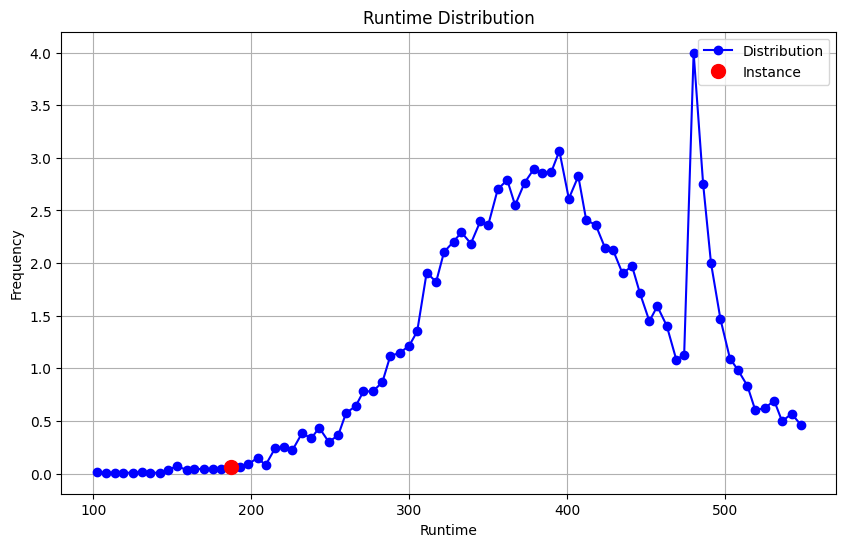

In [49]:
point = (int(row['runtime'].iloc[0]), row['frequency'])
plot_distribution(rt_dist['distribution'], 'Runtime', point)

In [50]:
import numpy as np

In [51]:
# get the nth percentile value of the distribution
def get_nth_percentile(distribution_df, percentile, metric):
    data = np.array(distribution_df[metric])
    return np.percentile(data, percentile)

# check if an instance of the distribution falls into the nth percentile
def is_within_nth_percentile(nth_percentile, instance):
    return instance <= nth_percentile

In [52]:
get_nth_percentile(dist_df, 25, 'runtime')

213.5

# Constructing the dataset

In [53]:
json_dataset = []

# Iterate over the 'train' split
for row in ds["train"]:
    # Runtime solutions
    runtime_efficient_codes = []
    runtime_inefficient_codes = []
    runtime_moderate_codes = []

    # Memory solutions
    memory_efficient_codes = []
    memory_inefficient_codes = []
    memory_moderate_codes = []

    # Get both runtime and memory distribution for the current problem
    runtime_distribution = to_pandas_df(json.loads(row['runtimeDistribution'])['distribution'], 'runtime')
    memory_distribution = to_pandas_df(json.loads(row['memoryDistribution'])['distribution'], 'memory')

    # Obtain the 25th and 75th percentile 
    runtime_twenty_fifth_percentile = get_nth_percentile(runtime_distribution, 25, 'runtime')
    runtime_seventy_fifth_percentile = get_nth_percentile(runtime_distribution, 75, 'runtime')

    for rt_item in row['rt_list']:
        # runtime of the current solution
        runtime = int(rt_item['runtime'])

        if runtime <= runtime_twenty_fifth_percentile:
            runtime_efficient_codes.append(rt_item)
        elif runtime >= runtime_seventy_fifth_percentile:
            runtime_inefficient_codes.append(rt_item)
        else:
            runtime_moderate_codes.append(rt_item)


    # Obtain the 75th percentile for both runtime and memory distribution
    memory_twenty_fifth_percentile = get_nth_percentile(memory_distribution, 25, 'memory')
    memory_seventy_fifth_percentile = get_nth_percentile(memory_distribution, 75, 'memory')

    # Applying the same concept as the above, but for memory efficent code
    for mm_item in row['mm_list']:
        # memory of the current solution
        memory = int(mm_item['memory'])

        if memory <= memory_twenty_fifth_percentile:
            memory_efficient_codes.append(mm_item)
        elif memory >= memory_seventy_fifth_percentile:
            memory_inefficient_codes.append(mm_item)
        else:
            memory_moderate_codes.append(mm_item)

    # Adding the test cases for the problem
    test_cases = [json.loads(obj) for obj in row['test_case'].strip().split('\n') if obj]

    json_data = {
        'question_id': row['question_id'],
        'name': row['name'],
        'prompt': row['content'],
        'difficulty': row['difficulty'],
        'topics': row['topics'],
        'runtime_inefficient_codes': runtime_inefficient_codes,
        'runtime_moderate_codes': runtime_moderate_codes,
        'runtime_efficient_codes': runtime_efficient_codes,
        'memory_inefficient_codes': memory_inefficient_codes,
        'memory_moderate_codes': memory_moderate_codes,
        'memory_efficient_codes': memory_efficient_codes,
        'entry_point': row['entry_point'],
        'import_code': row['import_code'],
        'setup_code': row['setup_code'],
        'test_cases': test_cases
    }

    json_dataset.append(json_data)


In [54]:
with open('dataset.json', 'w') as json_file:
    json.dump(json_dataset, json_file, indent=4)

In [55]:
df = pd.DataFrame(json_dataset)

# Creating a sample dataset with about 200 problems of different topics

In [56]:
import numpy as np

In [57]:


# Remove duplicate problems based on question_id
df_unique = df.drop_duplicates(subset='question_id').copy()

# Define a function to compute a diversity score for each problem
# based on the number of unique topics
def diversity_score(topics):
    # Check if topics is a list and return the count of unique topics
    return len(set(topics)) if isinstance(topics, list) else 0

# Create a new column 'diversity_score' based on the topics column
df_unique['diversity_score'] = df_unique['topics'].apply(diversity_score)

# Sort the DataFrame by diversity_score in descending order
df_sorted = df_unique.sort_values(by='diversity_score', ascending=False)

# Select 200 problems ensuring diverse topics
selected_samples = []  # list to store selected rows
collected_topics = set()  # set to track all topics added to the sample

for _, row in df_sorted.iterrows():
    # Ensure row['topics'] is a list; otherwise, default to an empty set
    problem_topics = set(row['topics']) if isinstance(row['topics'], list) else set()
    
    # Check if the problem introduces any new topics that are not already in collected_topics
    if not problem_topics.issubset(collected_topics):
        selected_samples.append(row)
        collected_topics.update(problem_topics)
    
    # Break once we have 200 samples
    if len(selected_samples) >= 200:
        break

# If the selected_samples list contains fewer than 200 problems,
# fill the remainder from the sorted DataFrame (excluding those already selected)
if len(selected_samples) < 200:
    remaining_needed = 200 - len(selected_samples)
    already_selected_ids = [row['question_id'] for row in selected_samples]
    remaining_df = df_sorted[~df_sorted['question_id'].isin(already_selected_ids)]
    additional_samples = remaining_df.head(remaining_needed).to_dict('records')
    selected_samples.extend(additional_samples)

# Convert selected_samples to a DataFrame
# Note: Convert each item to a dictionary to avoid issues if they are pandas Series
selected_samples_dict = [
    sample.to_dict() if isinstance(sample, pd.Series) else sample
    for sample in selected_samples
]

diverse_sample_df = pd.DataFrame(selected_samples_dict)

# Optional: Shuffle the final DataFrame to randomize the order
diverse_sample_df = diverse_sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the DataFrame to a JSON file with pretty printing (4-space indentation)
diverse_sample_df.to_json('samples.json', orient='records', indent=4)


In [58]:
# Display the first few rows of the resulting DataFrame
display(diverse_sample_df.head())

,question_id,name,prompt,difficulty,topics,runtime_inefficient_codes,runtime_moderate_codes,runtime_efficient_codes,memory_inefficient_codes,memory_moderate_codes,memory_efficient_codes,entry_point,import_code,setup_code,test_cases,diversity_score
0,1557,check-if-a-string-contains-all-binary-codes-of...,<p>Given a binary string <code>s</code> and an...,Medium,"[hash-table, string, bit-manipulation, rolling...",[{'code': 'class Solution: def hasAllCodes...,[{'code': 'class Solution: def hasAllCodes...,[{'code': 'class Solution: def hasAllCodes...,[{'code': 'class Solution: def hasAllCodes...,[{'code': 'class Solution: def hasAllCodes...,[{'code': 'class Solution: def hasAllCodes...,hasAllCodes,import random,"class Solution:\n def hasAllCodes(self, s: ...","[{'input': '011101011010010010|4', 'output': '...",5
1,1906,maximize-score-after-n-operations,"<p>You are given <code>nums</code>, an array o...",Hard,"[array, math, dynamic-programming, backtrackin...",[{'code': 'class Solution: def maxScore(se...,[{'code': 'import functools class Solution(o...,[{'code': 'class Solution: def maxScore(se...,[{'code': 'class Solution: def maxScore(se...,[{'code': 'class Solution: def maxScore(se...,[{'code': 'class Solution: def maxScore(se...,maxScore,from typing import List\nfrom functools import...,# Define the necessary data structures and any...,"[{'input': '{""nums"": [116740, 26226, 777573, 2...",7
2,808,number-of-matching-subsequences,<p>Given a string <code>s</code> and an array ...,Medium,"[array, hash-table, string, binary-search, dyn...",[{'code': 'class Solution: def numMatching...,[{'code': 'class Solution: def numMatching...,[{'code': 'from collections import Counter cl...,[{'code': 'class TrieNode: def __init...,[{'code': 'import bisect import collections cl...,[{'code': 'class Solution: def numMatching...,numMatchingSubseq,import random\nimport string,"class TrieNode:\n def __init__(self, c):\n ...","[{'input': 'mlcyifxcst|zuwf', 'output': '0'}, ...",7
3,3057,count-k-subsequences-of-a-string-with-maximum-...,<p>You are given a string <code>s</code> and a...,Hard,"[hash-table, math, string, greedy, combinatorics]","[{'code': 'mod=10**9+7 def nck(n,k): k=max...",[{'code': 'class Solution: def countKSubse...,[{'code': 'class Solution: def countKSubse...,[{'code': 'class Solution: def countKSubse...,[{'code': 'from collections import Counter fro...,[{'code': 'class Solution: def countKSubse...,countKSubsequencesWithMaxBeauty,from collections import Counter\nfrom itertool...,None,[{'input': 'qxqljoajrmrdoubjrktcibaoztnrddotru...,5
4,3218,find-number-of-coins-to-place-in-tree-nodes,<p>You are given an <strong>undirected</strong...,Hard,"[dynamic-programming, tree, depth-first-search...",[{'code': 'from sortedcontainers import Sorted...,[{'code': 'from sortedcontainers import Sorted...,[{'code': 'class Solution: def placedCoins...,[{'code': 'class Solution: def placedCoins...,[{'code': ' class Solution: def placedCoi...,[{'code': 'class Solution: def placedCoins...,placedCoins,from sortedcontainers import SortedList\nfrom ...,None,"[{'input': '{""edges"": [[0,1],[1,2],[2,3],[3,4]...",5


In [59]:
print(f"Length of samples: ", len(diverse_sample_df))
# Display the first few rows of the resulting DataFrame
display((diverse_sample_df['topics'].value_counts()))

Length of samples:  200


topics
[array, depth-first-search, breadth-first-search, union-find, matrix]                                     8
[array, binary-search, divide-and-conquer, binary-indexed-tree, segment-tree, merge-sort, ordered-set]    4
[array, dynamic-programming, backtracking, bit-manipulation, bitmask]                                     3
[array, dynamic-programming, stack, greedy, monotonic-stack]                                              3
[array, breadth-first-search, graph, heap-priority-queue, matrix, shortest-path]                          3
                                                                                                         ..
[array, hash-table, math, matrix, counting, enumeration, number-theory]                                   1
[array, hash-table, two-pointers, sorting, enumeration]                                                   1
[array, binary-search, greedy, sorting, prefix-sum]                                                       1
[array, hash-table, m